# Solution using ResBlocks
Solution by Luca Lanzo

### Problem description

The classification of the Fashion-MNIST dataset is a good opportunity to test out an MLP model using residual blocks (ResBlocks).

### Proposed solution
Use the standard Fashion-MNIST dataset from the torchvision library to train a model able to classify the images by their type.

## Coded Solution

### Step 1: Importing all necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Step 2: Setup CUDA for parallel computation
While the sequential computations run on the CPU, Pytorch can offload the heavy duty parallel computations onto the GPU.  
Not every user running this notebook has CUDA enabled so I have coded a short device check which creates the data and the model either on CUDA or CPU.

In [2]:
print(f'Cuda available: {torch.cuda.is_available()}')

device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda available: True


### Step 3: Get the Fashion-MNIST train and test dataset

In [3]:
mnist_train = datasets.FashionMNIST(root='datasets', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.FashionMNIST(root='datasets', train=False, download=True, transform=transforms.ToTensor())

### Step 4: Instantiate the DataLoaders

In [4]:
batch_size = 128
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

### Step 5: Defining the MLP model

#### Step 5.1: Defining the ResBlock first
The ResBlock is defined as its own layer using the subclass of nn.Module

In [5]:
class ResBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.d1 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(out_channels, out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.fc2 = nn.Linear(out_channels, out_channels)
        
    def forward(self, x):
        identity = x
        
        # batchnorm, relu, dropout
        out = self.d1(F.relu(self.bn1(x)))
        
        # fully connected, batchnorm, relu
        out = F.relu(self.bn2(self.fc1(out)))
        
        # fully connected
        out = self.fc2(out)
        
        # Skip the connection here via addition --- https://theaisummer.com/skip-connections/
        out += identity
        
        return out

#### Step 5.2: Defining the MLP after
The output channels are variable, so that the user can set them on object initialisation.

In [6]:
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, out_channels[0])
        
        self.rb1 = ResBlock(out_channels[0])
        
        self.bn1 = nn.BatchNorm1d(out_channels[0])
        self.fc2 = nn.Linear(out_channels[0], out_channels[1])
        
        self.rb2 = ResBlock(out_channels[1])
        
        self.bn2 = nn.BatchNorm1d(out_channels[1])
        self.fc3 = nn.Linear(out_channels[1], out_channels[2])
            
    def forward(self, x):
        # no need to flatten x as it has already been flattened in the model_training method
        # fully connected
        x = self.fc1(x)

        # ResBlock with skip
        x = self.rb1(x)
        
        # batch norm, relu, fully connected
        x = self.fc2(F.relu(self.bn1(x)))
        
        # ResBlock with skip
        x = self.rb2(x)
        
        # batch norm, relu, fully connected
        x = self.fc3(F.relu(self.bn2(x)))
        
        return x

#### Step 5.3: Initialise the model and transfer to GPU if possible

In [7]:
model = MLP(in_channels=784, out_channels=(256, 64, 10))

# send the model to CUDA
model.to(device)
print(f'Model has been transferred to CUDA: {next(model.parameters()).is_cuda}')

Model has been transferred to CUDA: True


### Step 6: Define the loss function
The loss function is defined as the cross-entropy loss.

In [8]:
loss_func = nn.CrossEntropyLoss()

### Step 7: Define the optimisation algorithm
The optimisation algorithm is defined as the SGD algorithm.

In [9]:
optimiser = optim.SGD(model.parameters(), lr=0.1)
# optimiser = optim.RMSprop(model.parameters(), lr=0.1)

### Step 8: Model training procedure

In [10]:
def model_training(trainloader, model, loss_func, optimiser):
    num_epochs = 100 # tweak for optimisation
    
    losses = []
    
    # Set the model to training mode
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (images, labels) in enumerate(trainloader):
            # transfer data to GPU
            images, labels = images.to(device), labels.to(device)
            
            # flatten the images into a 784 long vector
            images = torch.flatten(images, 1)
            
            # training pass
            optimiser.zero_grad()
            
            # get predictions
            output = model(images)
            
            # get loss value
            loss = loss_func(output, labels)
            
            # go in the direction opposite of the gradient
            loss.backward()
            
            # update parameter values
            optimiser.step()
            
            running_loss += loss.item()
            
        losses.append(running_loss/i)
        print(f'Epoch {epoch+1}/{num_epochs} --- Loss {running_loss/i}')
        
    return losses

In [11]:
losses = model_training(trainloader, model, loss_func, optimiser)

Epoch 1/100 --- Loss 0.5662765769749625
Epoch 2/100 --- Loss 0.3947461422883038
Epoch 3/100 --- Loss 0.35294894074909705
Epoch 4/100 --- Loss 0.3310750950860162
Epoch 5/100 --- Loss 0.31217433244754106
Epoch 6/100 --- Loss 0.29599533570755243
Epoch 7/100 --- Loss 0.28258587375410604
Epoch 8/100 --- Loss 0.2734647587928762
Epoch 9/100 --- Loss 0.26338279454244506
Epoch 10/100 --- Loss 0.2526847023803454
Epoch 11/100 --- Loss 0.24408032834275156
Epoch 12/100 --- Loss 0.23449170700887328
Epoch 13/100 --- Loss 0.22829977464344767
Epoch 14/100 --- Loss 0.21810699440538883
Epoch 15/100 --- Loss 0.21122880085793316
Epoch 16/100 --- Loss 0.20581975837166494
Epoch 17/100 --- Loss 0.20186008191388896
Epoch 18/100 --- Loss 0.19316137039190173
Epoch 19/100 --- Loss 0.1880124103055041
Epoch 20/100 --- Loss 0.18122832868725824
Epoch 21/100 --- Loss 0.17711367680985704
Epoch 22/100 --- Loss 0.1711478642641734
Epoch 23/100 --- Loss 0.16639165970313752
Epoch 24/100 --- Loss 0.1601650334146415
Epoch 25/

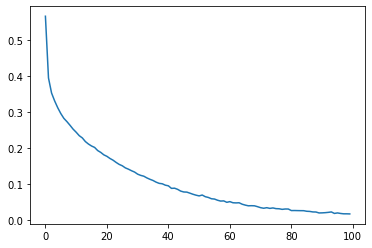

In [12]:
# plot the losses after finishing the training
plt.plot(losses)

### Step 9: Test model on the first couple of test images
Important: The model has to be set to evaluation mode in order to turn off Dropout and BatchNorm (and other layers/parts of the model). The model has also been transferred back to the CPU because the training has been finished.

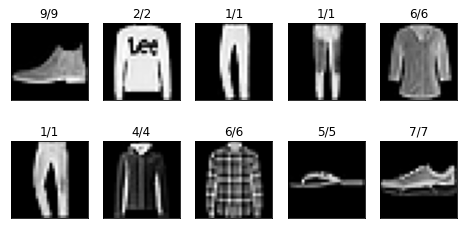

In [13]:
# set the model to evaluation mode and send it back to the CPU
model.eval()
model.to('cpu')

fig, axs = plt.subplots(2, 5)
fig.set_size_inches(8, 4)
axs = axs.flatten()

for i, (images, labels) in enumerate(mnist_test):
    axs[i].imshow(images.squeeze(), cmap='gray')
    
    outputs = model(torch.flatten(images, 1))
    outputs = torch.argmax(outputs, dim=1)
    
    axs[i].set_title(f"{labels}/{outputs.item()}")
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
    if i == 9:
        break

### Step 10: Check the overall performance on all test images

The accuracy of the model on all test images is 89.52 %


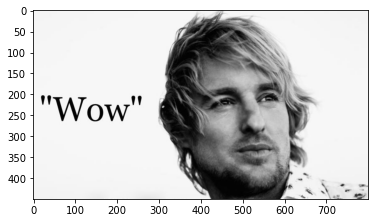

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(torch.flatten(images, 1))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'The accuracy of the model on all test images is {100 * correct / total} %')

if ((100 * correct / total) > 85):
    plt.imshow(plt.imread('important_reaction_picture.jpg'))

### Step 11: Evaluating the model and the performance

This assignment was a lot of fun and I learned a lot :) Here are my results...   


_lr=0.05, epochs=5, batch_size=128_  
On my first ever try i used the hyperparameters from the second assignment and got an overall performance of 87.34 % on the unseen test data. Even on the first try I exceeded the accuracy on the last assignment with 83.25 %.  
Although, it didn't look like the loss was plateauing yet. Let's give it some more time to wind down.

_lr=0.05, **epochs=20**, batch_size=128_   
The accuracy went up to 89.16 %. Nice. But let's give it some more time.

_lr=0.05, **epochs=50**, batch_size=128_  
89.25 %. Hm, not much improvement. Maybe changing the learning rate does something.

---
_**lr=0.1**, **epochs=10**, batch_size=128_  
88.15 %. Not really a big difference compared to lr=0.05. Maybe I should let it run a lot longer as it still looked like the loss plateau wasn't reached yet.

_lr=0.1, **epochs=100**, batch_size=128_  
89.52 %! Great accuracy and for the first time the loss looked like it reached a minimum. But I wonder if adding some momentum might find a better minimum.

---
_lr=0.1, epochs=100, batch_size=128, **momentum=0.9**_  
Still, no real difference with 89.18 %. 


---
I will stop at this point and choose the following hyper parameters for my model:  
**lr=0.1, epochs=100, batch_size=128**: This will yield a good result with which I am content. I could let it run longer, but the accuracy is as good as it gets I think.

### Just for fun  
I stumbled accross this article on my search to improve hyperparameters:  
https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/  

It was a great read which made me try out rmsprop just for fun.

The optimiser is commented out but can be enabled.

RMSprop with _lr=0.1, epochs=100, batch_size=128_    
Test accuracy: 87,43 %  
Well, it was worth a try. I believe there are some major improvements to the optimiser and hyperparameters but I do not have the experience yet to find it out myself which is why I am sticking to my solution above.